**Pré-processamentos**:

- **Remoção de fundo**: Remover o fundo da imagem para reduzir a complexidade do aprendizado pelo modelo, dada a variabilidade de cores, contraste e iluminação entre as imagens;

- **Conversão para escala de cinza**: Como a cor não é uma informação relevante para detecção do gesto, as imagens serão convertidas para escala de cinza;

- **Realce e ajuste de iluminaçao**: aplicação de maior contraste nas cores da imagem para aprimorar o facilitar a detecção da posição dedos na frente da palma da mão. Além disso, diferentes imagens estao com diferentes níveis de iluminação. Dessa forma, corrigir as variaçoes de iluminação para dar destaque às mãos;

- **Suavização para redução de ruídos**: Aplicar filtros de suavizaçao para reduçao de ruídos afim de facilitar a detecçao das bordas;

- **Detecção de borda**: Detecção das bordas para mapear o formato exato da mão;

- **Normalização**: Normalizar os pixels da imagem;

- **Segmentação**: Há imagens em que o antebraço está completamente exposto, enquanto que há imagens em que o antebraço praticamente não aparece. Nesse caso, segmentar apenas a mão é importante;

## Configuração Inicial

Configuração e import de bibliotecas, além da definição da imagem de referência.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from rembg import remove
from opendatasets import download
from statistics import geometric_mean
from math import log10

plt.rcParams['axes.grid'] = False  # Desativa as grades nos plots.

## Download de Dataset

A célula abaixo realiza o download do dataset diretamente usando a API do Kaggle em seu repositório local e o redimensiona, eliminando o excesso de amostras.  

In [13]:
download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

from funcoes_locais import redimensionar_dataset
redimensionar_dataset(150)  # Vamos usar apenas 75 amostras por classe.

Skipping, found downloaded files in ".\asl-alphabet" (use force=True to force download)
Dataset já possui 150 amostras por classe.


## Primeiras Impressões das Imagens

Vamos plotar a imagem de referência para termos a primeira impressão, e a partir disso, realizar o pré-processamento.

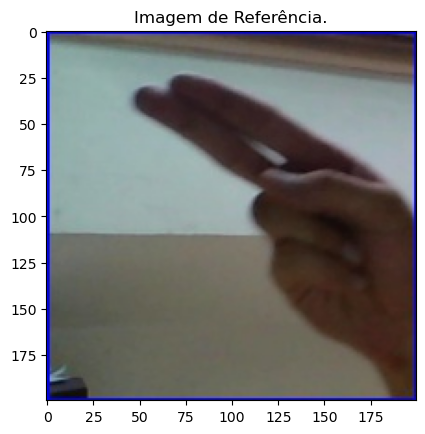

In [14]:
imagem = cv2.imread('asl-alphabet/asl_alphabet_test/asl_alphabet_test/H_test.jpg')
image_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Imagem de Referência.")
plt.show()

Vamos agora, explorar as propriedades da imagem, como suas dimensões e tipo de encoding.

In [15]:
altura, largura, canais = imagem.shape

propriedades = [
    ('Altura:', altura),
    ('Largura:', largura),
    ('Canais de cor:', canais),
    ('Tipo de dado:', imagem.dtype),
    ('Desvio Padrão', imagem.std())
]

for propriedade, valor_propriedade in propriedades:
    print(f'{propriedade} {valor_propriedade}')


Altura: 200
Largura: 200
Canais de cor: 3
Tipo de dado: uint8
Desvio Padrão 50.31525571282131


Passando para os canais da imagem, vamos usar a função np.asarray(), que irá tabular a imagem em forma numérica, possibilitando a separação de canais.  
Tendo em vista cada canal separado, é possível analisar qual cor possui o maior impacto no elemento desejado da imagem, possibilitando aplicar outras operações.
Abaixo, o código para separação e representação.

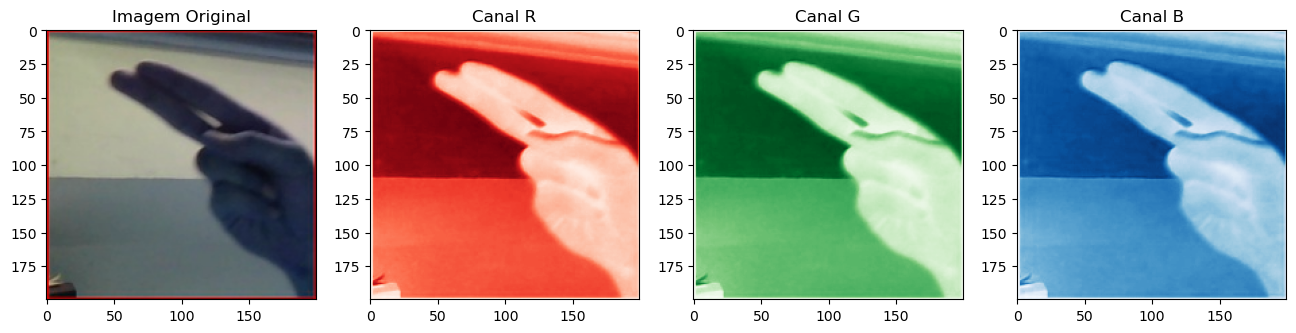

In [16]:
matriz_imagem = np.asarray(imagem)

plt.figure(figsize=(16,8))
plt.subplot(141)

plt.imshow(imagem)
plt.title("Imagem Original")
plt.subplot(142)

plt.imshow(matriz_imagem[:, :, 1], cmap="Reds")
plt.title("Canal R")
plt.subplot(143)

plt.imshow(matriz_imagem[:, :, 1], cmap="Greens")
plt.title("Canal G")
plt.subplot(144)

plt.imshow(matriz_imagem[:, :, 2], cmap="Blues")
plt.title("Canal B")
plt.show()

## Pré-processamento de Imagens

Começaremos por remover o fundo da imagem, para facilitar o processamento.

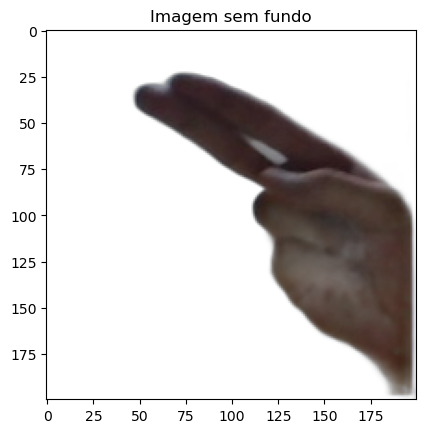

In [17]:
img_sem_fundo = remove(image_rgb)

plt.imshow(img_sem_fundo)
plt.title('Imagem sem fundo')
plt.show()

Como os gestos não são dependentes de cores para serem reconhecidos, mas sim dos formatos, vamos converter a imagem para preto e branco.  
Trabalhar com imagens na escala cinza também reduz o custo computacional para realizar processos nas imagems.

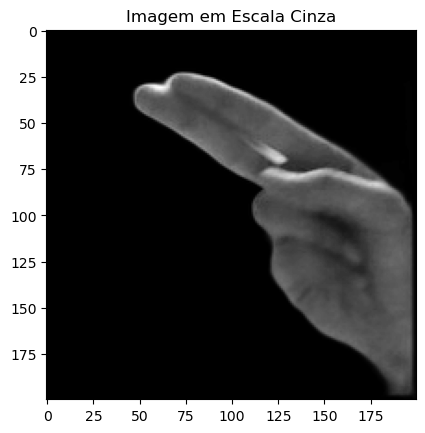

In [18]:
imagem_cinza = cv2.cvtColor(img_sem_fundo, cv2.COLOR_RGB2GRAY)  # Conversão para escala cinza.
plt.imshow(imagem_cinza, cmap="gray")
plt.title("Imagem em Escala Cinza")
plt.show()

Uma vez na escala de cinza, a fim de ajustar o contraste e facilitar a identificaçao das principais características da imagem, aplica-se técnicas de realce.

C:\Users\Kafat\AppData\Local\Temp\ipykernel_15488\23971408.py:9: RuntimeWarning: divide by zero encountered in power
  img_gamma = (np.power(imagem_cinza/255, gamma)*255).astype(np.uint8)
C:\Users\Kafat\AppData\Local\Temp\ipykernel_15488\23971408.py:9: RuntimeWarning: invalid value encountered in cast
  img_gamma = (np.power(imagem_cinza/255, gamma)*255).astype(np.uint8)


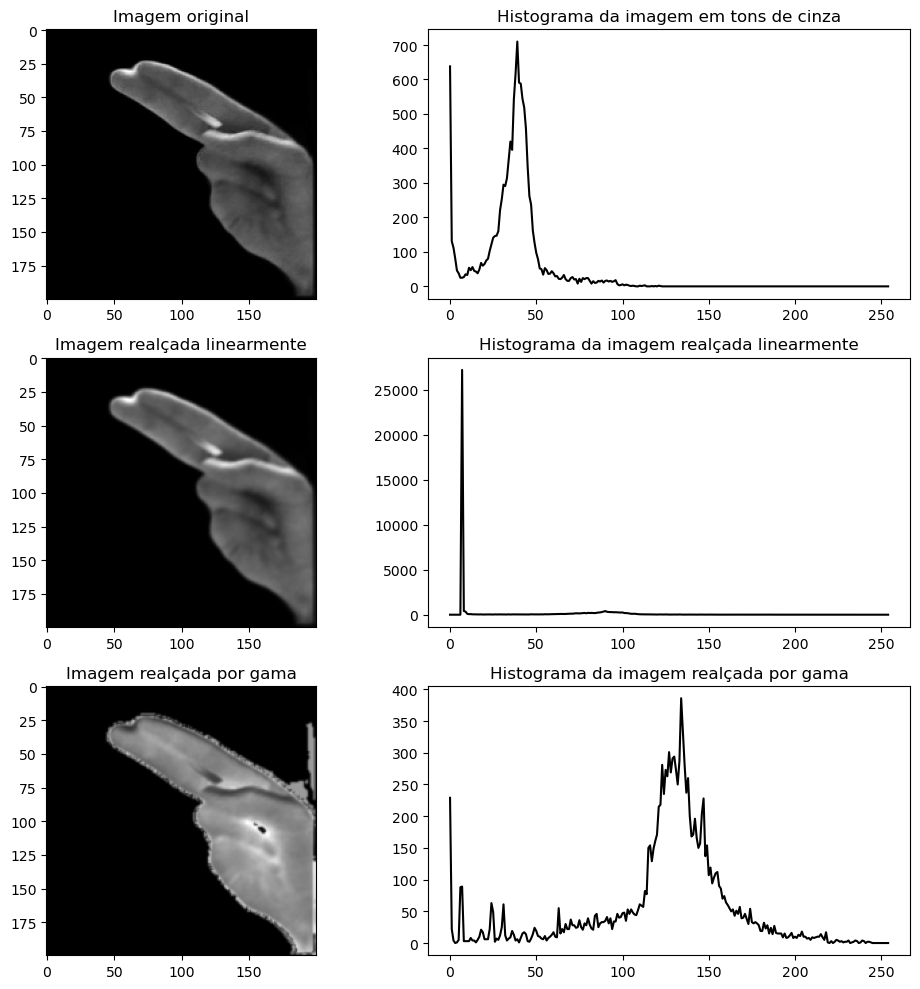

In [19]:
# Realce por filtro linear
alpha = 40/(1.7*imagem_cinza.mean())
img_equal = cv2.convertScaleAbs(imagem_cinza, alpha = alpha, beta = 8)
img_equal = cv2.GaussianBlur(img_equal, (5,5), 0.9, 0.9)

# Realce por correção gama:
vetor = [i+1 for i in np.reshape(imagem_cinza, -1)] #conversao de imagem cinza para uma dimensao
gamma = log10(200/255)/log10(geometric_mean(vetor)) #calculo do melhor gama
img_gamma = (np.power(imagem_cinza/255, gamma)*255).astype(np.uint8)
img_gamma = cv2.GaussianBlur(img_gamma, (5,5), 0.7, 0.7)

# Obtenção dos histogramas:
hist_cinza = cv2.calcHist([imagem_cinza],[0],None,[255],[1,256])
hist_equal = cv2.calcHist([img_equal],[0],None,[255],[1,256])
hist_gamma = cv2.calcHist([img_gamma],[0], None, [255], [1, 256])

# Impressão das imagens
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.imshow(imagem_cinza, cmap='gray')
plt.title("Imagem original")

plt.subplot(3,2,2)
plt.plot(hist_cinza, color='black')
plt.title('Histograma da imagem em tons de cinza')

plt.subplot(3,2,3)
plt.imshow(img_equal, cmap='gray')
plt.title("Imagem realçada linearmente")

plt.subplot(3,2,4)
plt.plot(hist_equal, color='black')
plt.title('Histograma da imagem realçada linearmente')

plt.subplot(3,2,5)
plt.imshow(img_gamma, cmap='gray')
plt.title('Imagem realçada por gama')

plt.subplot(3,2,6)
plt.plot(hist_gamma, color='black')
plt.title('Histograma da imagem realçada por gama')

plt.tight_layout()
plt.show();

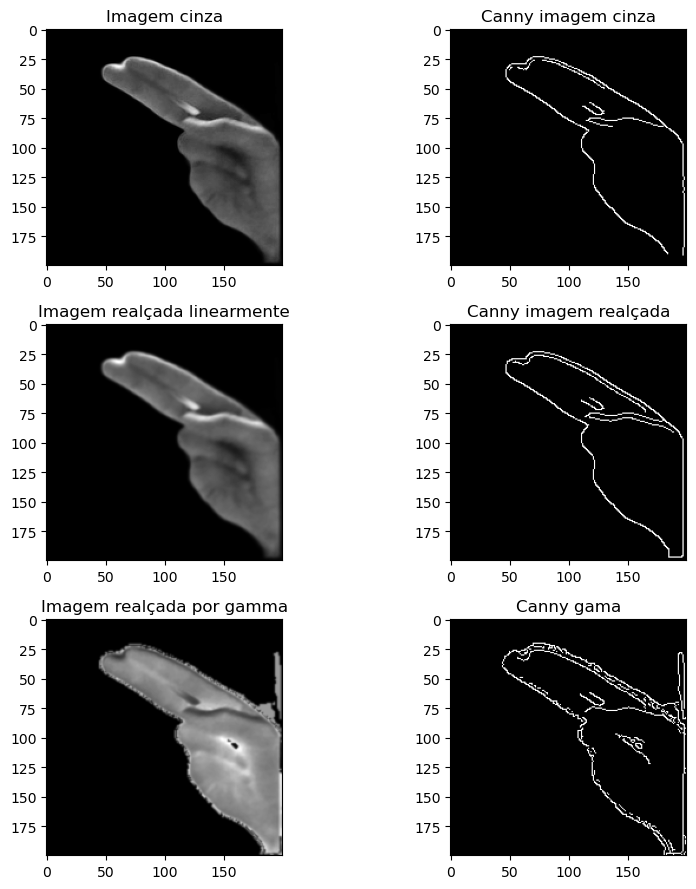

In [20]:
img_canny1 = cv2.Canny(imagem_cinza, threshold1=90,threshold2=200)
img_canny2 = cv2.Canny(img_equal, threshold1=90,threshold2=200)
img_canny3 = cv2.Canny(img_gamma, threshold1=90, threshold2=200)

plt.figure(figsize=(9,9))

plt.subplot(3,2,1)
plt.imshow(imagem_cinza, cmap='gray')
plt.title('Imagem cinza')
plt.subplot(3,2,2)
plt.imshow(img_canny1, cmap='gray')
plt.title('Canny imagem cinza')
plt.subplot(3,2,3)
plt.imshow(img_equal, cmap='gray')
plt.title('Imagem realçada linearmente')
plt.subplot(3,2,4)
plt.imshow(img_canny2, cmap='gray')
plt.title('Canny imagem realçada')
plt.subplot(3,2,5)
plt.imshow(img_gamma, cmap='gray')
plt.title('Imagem realçada por gamma')
plt.subplot(3,2,6)
plt.imshow(img_canny3, cmap='gray')
plt.title('Canny gama')

plt.tight_layout()

Percebe-se que Canny apresentou um desempenho melhor que Sobel.

Além disso, para aplicação de Canny, não precisa realizar o realce da imagem. O próprio algoritmo de Canny
realiza o cálculo dos gradientes aplicando sobel para encontrar as bordas e também aplica um um filtro gaussiano
para redução de ruído.

Para processamento da imagem pela rede neural, é importante a normalizaçao de seus pixels.

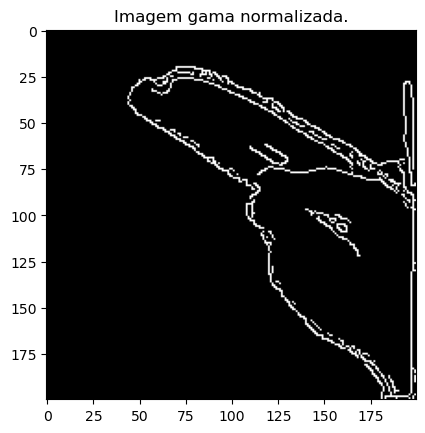

In [21]:
img_norm = img_canny3/255

plt.imshow(img_norm, cmap='gray')
plt.title("Imagem gama normalizada.")
plt.show()

O pré-processamento final ficou conforme função abaixo.
Neste caso, está descrito também no módulo funcoes_locais, para ser usado em outros notebooks.   
Com isso, foi encerrado a análise exploratória, e vamos ao notebook de modelagem para realizar o treinamento.

In [22]:
"""
def preprocessar_imagem(imagem_cv2):
        img = cv2.imread(imagem_cv2)
        img_no_back = remove(img)
        img_gray = cv2.cvtColor(img_no_back, cv2.COLOR_RGB2GRAY)

        alpha = 40 / (1.7 * img_gray.mean())
        img_equal = cv2.convertScaleAbs(img_gray, alpha=alpha, beta=8)
        img_equal = cv2.GaussianBlur(img_equal, (5, 5), 0.9, 0.9)
        
        img_canny = cv2.Canny(img_equal, threshold1=90, threshold2=200)
        img_canny = img_canny / 255
""";